# Comparison of deep learning reinforcement methods when learning rules in a custom environment

In [2]:
%load_ext autoreload

In [3]:
%autoreload on
import torch
import torch.nn as nn
from torch import tensor as tt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.distributions import Categorical
import collections
import random
import pickle
import time
import seaborn as sns
sns.set_style('darkgrid')

# Custom file imports
import Scripts.trumps_no_pile as tnp
import Scripts.trumps_five_cards as tfc
import Scripts.fake_bots_architecture as far
import Scripts.fake_bots as fb
from Scripts.helpers import *

from Scripts.actor_critic import A2Cnet, ac_runner
from Scripts.epsilon_greedy_1 import eg_model, eg_runner
from Scripts.epsilon_greedy_2 import eg2_model, eg2_runner
from Scripts.policy_gradient import PolicyGradient, policy_runner


# Contents

- [Introduction](#intro)
- [Setup](#basic)
- [One card](#oc)
    - [Epsilon greedy 1](#epg1)
    - [Epsilon greedy 2](#epg2)
    - [Policy gradients](#pg)
    - [Actor Critic](#ac1)
- [Two card](#tc)
    - [Epsilon greedy 1](#epg12)
    - [Epsilon greedy 2](#epg22)
    - [Policy gradients](#pg2)
    - [Actor Critic](#ac2)
- [Five card](#fc)
    - [Epsilon greedy 1](#epg13)
    - [Epsilon greedy 2](#epg23)
    - [Policy gradients](#pg3)
    - [Actor Critic](#ac3)
- [Five card with rules](#fcwr)

# Introduction

<a id="intro"></a>

In this project I set out to compare how efficiently different reinforcement learning methods could learn the rules of the card game 'Trumps'. All the fine details are set out in the project report, including what the game is, how the training works, what the loss functions are etc

The 4 methods to compare are:

- Epsilon Greedy 1
- Epsilon Greedy 2 (same as 1 but now with replay / offline learning instead)
- Policy Gradients
- Actor Critic

To enable this project I made the custom environment 'Trumps' in Python. I then created the architecture for all 4 different methods using OOP, This notebook calls all these methods, and presents the results.

All the supporting code can be found within the 'scripts' folder. 

Technologies used: Python, PyTorch, Numpy, Matplotlib, Seaborn

# Setup

<a id="basic"></a>

I will run 3 different 'tests' for our bots. Trumps with one, two or 5 cards. For one / two cards the observation space is simply a one-hot encoded list length 52, with value 1 if the card is in the hand, else 0.

For 5 cards, we also return a one-hot encoded list for the 'pile' (cards that have been played already), and which suit the trump is. 

# One card

<a id="oc"></a>

We will train for $\sim$ 20,000 - 50,000 games, as this task is relatively easy. All our bots have to do is learn to pick the action which corresponds to the '1' in the observation space

In [6]:
env = tnp.SuperTrumps()
n_obs = env.observation_space[0]
n_actions = env.action_space

### Epsilon greedy attempt 1

<a id="epg1"></a>

.................................................20000
.

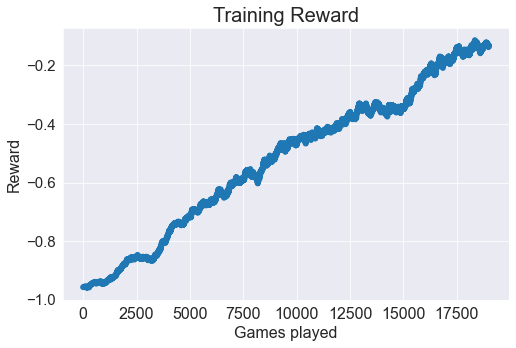

<Figure size 432x288 with 0 Axes>

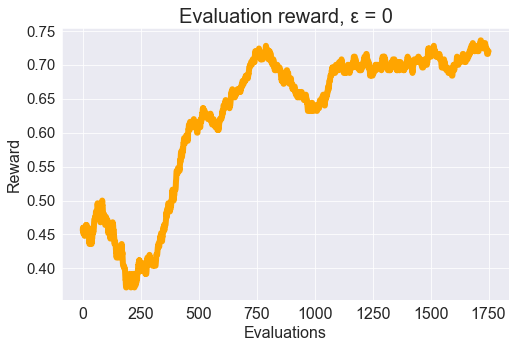

Is the model still making mistakes?
False


In [4]:
eg_agent = eg_model(n_obs, n_actions)
model = eg_runner(eg_agent, env, num_updates=20000, min_epsilon=0.5)
train_model(model, True)
        

### Epsilon greedy with replay memory

<a id="epg2"></a>

..................................................25000
..................................................50000


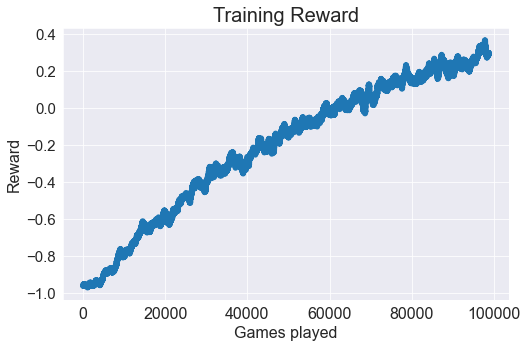

<Figure size 432x288 with 0 Axes>

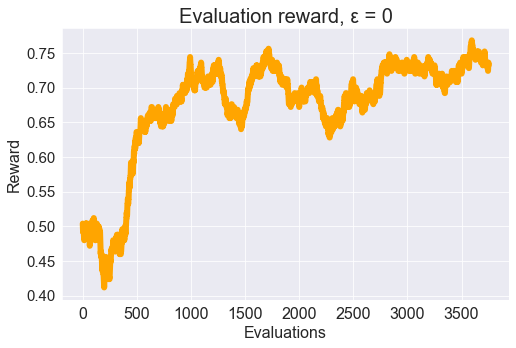

Is the model still making mistakes?
False


In [5]:
eg2_agent = eg2_model(n_obs, n_actions)
model = eg2_runner(eg2_agent, env, num_updates=50000, min_epsilon=0.5)
train_model(model, True)
        

### Policy gradient

<a id="pg"></a>

.................................................20000
..................................................40000
..........................

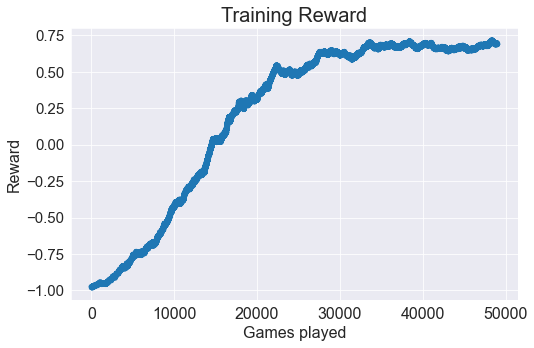

Is the model still making mistakes?
False


In [7]:
pg_agent = PolicyGradient(n_obs, n_actions)
model = policy_runner(pg_agent, env, num_updates=50000)

train_model(model, False)
        

### Actor Critic

<a id="ac1"></a>

.................................................20000
..................................................40000
..................................................60000
.

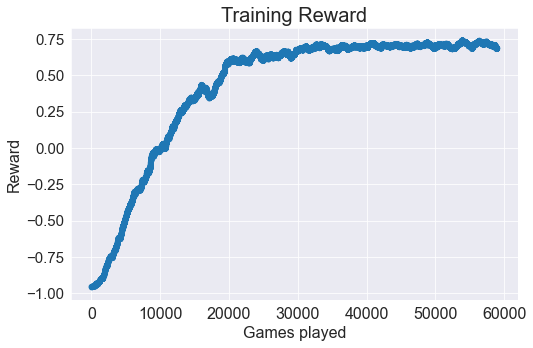

Is the model still making mistakes?
True


In [8]:
agent = A2Cnet(n_obs, n_actions)
model = ac_runner(agent, env, num_updates=60000, num_obs=n_obs)

train_model(model, False)

Even after 60,000 games, the Actor Critic bot still is making mistakes. This could be addressed by longer training, removal of the entropy term in the loss function, or by limiting the probability of actions (for example, probability >= 0.01, 0.001 etc)

# Two Cards

<a id="tc"></a>

We will train for $\sim$ 50,000 - 100,000 games, as this task is relatively easy but a little harder than before. Now our bots have to learn that there are potentially 2 options for what they can play.

Intuitively you might think this would be even easier to train. However, tuning the network parameters may be harder for the bot now, as extra moves are permitted at each step.

In [8]:
env = tnp.SuperTrumps(num_cards=2)
n_obs = env.observation_space[0]
n_actions = env.action_space

### Epsilon greedy attempt 1

<a id="epg12"></a>

.................................................20000
..................................................40000
..........................

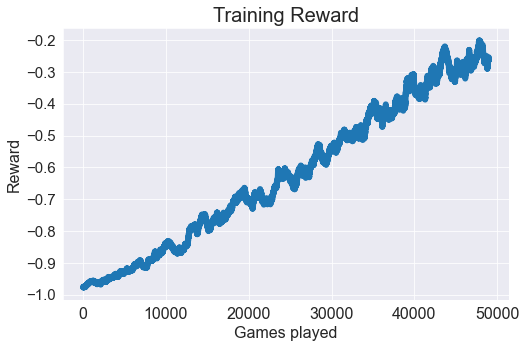

<Figure size 432x288 with 0 Axes>

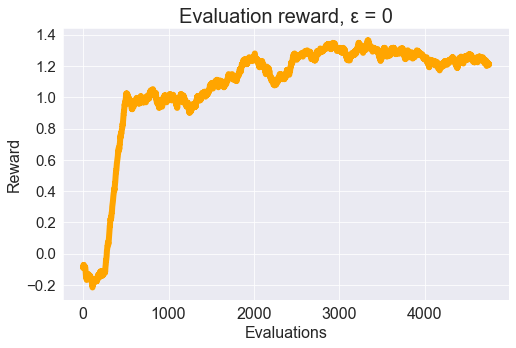

Is the model still making mistakes?
False


In [9]:
eg_agent = eg_model(n_obs, n_actions)
model = eg_runner(eg_agent, env, num_updates=50000, min_epsilon=0.5)
train_model(model, True)


### Epsilon greedy with replay memory

<a id="epg22"></a>

..................................................25000
..................................................50000


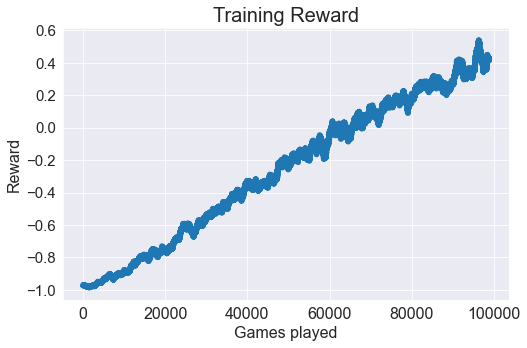

<Figure size 432x288 with 0 Axes>

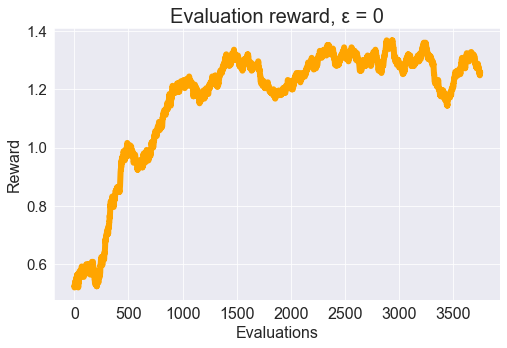

Is the model still making mistakes?
False


In [10]:
eg2_agent = eg2_model(n_obs, n_actions)
model = eg2_runner(eg2_agent, env, num_updates=50000, min_epsilon=0.5)
train_model(model,True)

### Policy gradient

<a id="pg2"></a>


.................................................20000
..................................................40000
..................................................60000
..................................................80000
..................................................100000
.

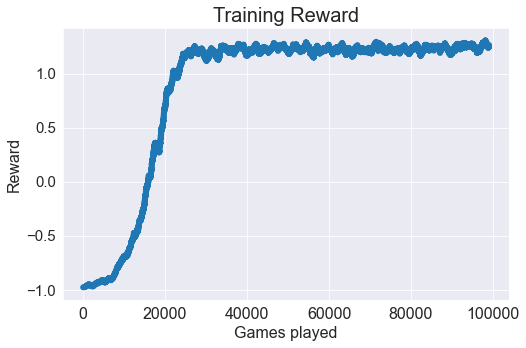

Is the model still making mistakes?
True


In [12]:
pg_agent = PolicyGradient(n_obs, n_actions)
model = policy_runner(pg_agent, env, num_updates=100000)

train_model(model, False)
        

### Actor Critic

<a id="ac2"></a>

.................................................20000
..................................................40000
..................................................60000
..................................................80000
..................................................100000
.

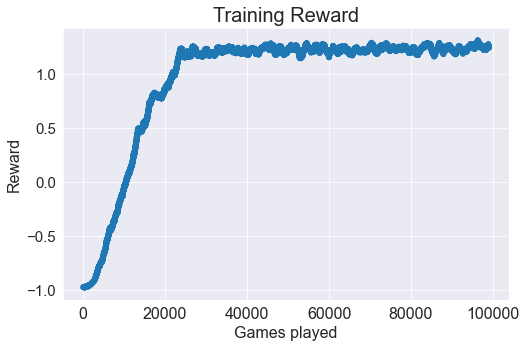

Is the model still making mistakes?
True


In [13]:
agent = A2Cnet(n_obs, n_actions)
model = ac_runner(agent, env, num_updates=100000, num_obs=n_obs)

train_model(model, False)

Now the Policy Gradient & Actor Critic bots are still making mistakes. The average reward very quickly gets to nearly the perfect value, so this is not too worrying

# Five Cards

<a id="fc"></a>

Much more difficult challenge, as now our bots have to factor in what card has been played by the opponent, which restricts the valid moves it can make.

## Epsilon greedy attempt 1
<a id="epg13"></a>

In [4]:
env = tfc.SuperTrumps(num_cards=5)
n_actions = env.action_space
n_obs = env.observation_space[0]

.................................................20000
..................................................40000
..................................................60000
..................................................80000
..................................................100000
..................................................120000
..................................................140000
..................................................160000
..................................................180000
..................................................200000
..................................................220000
..................................................240000
..................................................260000
..................................................280000
..................................................300000
..................................................320000
..................................................340000
....................................

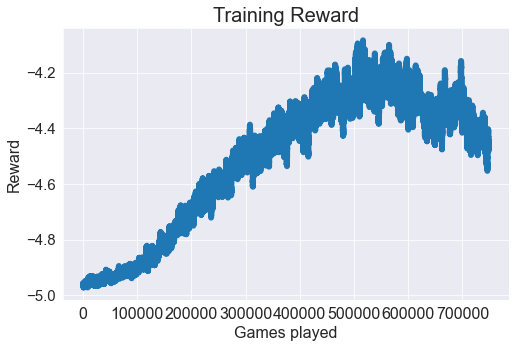

<Figure size 432x288 with 0 Axes>

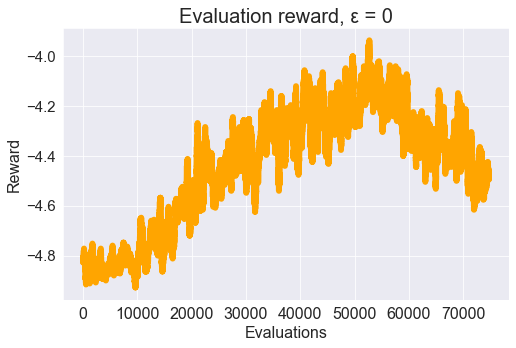

Is the model still making mistakes?
True
saving model...


FileNotFoundError: [Errno 2] No such file or directory: 'models/epsilon_greedy_1_model'

In [24]:
eg_agent = eg_model(n_obs, n_actions, lr=1e-3)
model = eg_runner(eg_agent, env, num_updates=750000, min_epsilon=0.01)
train_model(model, True, save=True)

# with open('Scripts//models//epsilon_greedy_1_model', 'rb') as f:
#     eg_model = pickle.load(f)
    
# plot_both_graphs(eg_model.sum_rewards, eg_model.scores)

# print('Time taken for the model to run: 73.4 minutes')

## Epsilon greedy with replay memory

<a id="epg23"></a>

..................................................25000
..................................................50000
..................................................75000
..................................................100000
..................................................125000
..................................................150000
..................................................175000
..................................................200000
..................................................225000
..................................................250000
..................................................275000
..................................................300000
..................................................325000
..................................................350000
..................................................375000
..................................................400000
..................................................425000
..................................

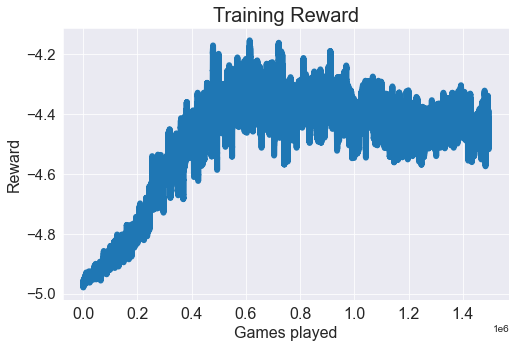

<Figure size 432x288 with 0 Axes>

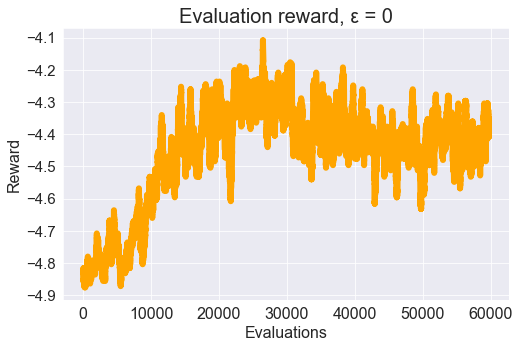

Is the model still making mistakes?
True
saving model...


In [5]:
eg2_agent = eg2_model(n_obs, n_actions)
model = eg2_runner(eg2_agent, env, num_updates=750000, lr=1e-3, min_epsilon=0.01)
train_model(model, True, save=True)

# with open('models/epsilon_greedy_2_model', 'rb') as f:
#     eg2_model = pickle.load(f)

# plot_both_graphs(eg2_model.sum_rewards, eg2_model.scores)

# print('Time taken for the model to run: 79.3 minutes')

## Policy gradient

<a id="pg3"></a>

.................................................20000
..................................................40000
..................................................60000
..................................................80000
..................................................100000
..................................................120000
..................................................140000
..................................................160000
..................................................180000
..................................................200000
..................................................220000
..................................................240000
..................................................260000
..................................................280000
..................................................300000
..................................................320000
..................................................340000
....................................

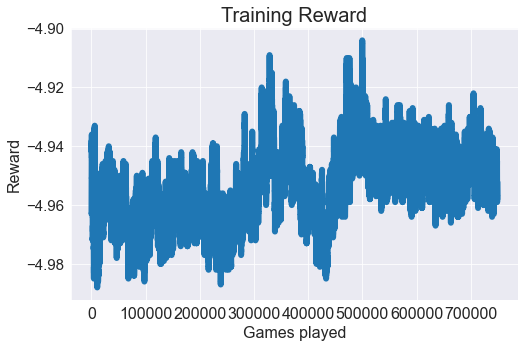

Is the model still making mistakes?
True
saving model...


In [6]:
pg_agent = PolicyGradient(n_obs, n_actions)
model = policy_runner(pg_agent, env, num_updates=750000, lr=1e-3)
train_model(model, False, save=True)

# with open('models/policy_gradient_model', 'rb') as f:
#     pg_model = pickle.load(f)

# Above wont work as the file is too big for github

# plot_training_graph(pg_model.sum_rewards)

# print('Time taken for the model to run: 71.1 minutes')

## Actor Critic

<a id="ac3"></a>

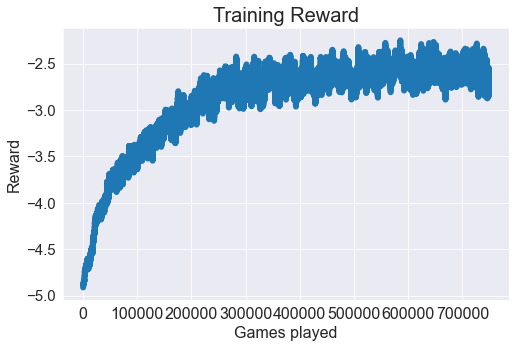

Time taken for the model to run: 209.82 minutes


In [12]:
# agent = A2Cnet(n_obs, n_actions)
# model = ac_runner(agent, env, num_updates=750000, num_obs=n_obs)

# train_model(model, False, save=True)

# with open('models/actor_critic_model', 'rb') as f:
#     ac_model = pickle.load(f)
# Above wont work as the file is too big for github

plot_training_graph(ac_model.sum_rewards)

print('Time taken for the model to run: 209.82 minutes')
print('Model is still making mistakes of course')

All bots struggle here, but actor critic comes out on top by a long shot actually. This is the only bot sophisticated enough to learn the details, given the simple network architecture (though epsilon greedy may have potential, but would take a lot longer to train)

#  Conclusion

That is it for this notebook! Please do read the project report for loads more detail (and nicer presentation), including a more thorough discussion. Please see my other code for details of how this was possible, and please feel free to message me on the details below with any questions / comments / advice / ideas.

Thanks!

# About / linkedin

Linkedin:
- linkedin.com/in/CharlieGaynor

Email:
- CharlieJackGaynor@gmail.com